# Introduction

We've found that plotting fragments in promoters (FRIP) vs UMI identifies high quality nuclei barcodes. We extract these for further processing and discard the rest.

# Setup

In [12]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [16]:
mountpoint = '/data/clue/'
prefix = mountpoint + 'amo/atac/'

# Load in Samples

In [3]:
data = dict()
samples = ['cellranger.outs/well%d/outs/' % i for i in range(1,6)]

In [4]:
data['sc'] = dict()
data['umis'] = dict()
data['frip'] = dict()
for sample in samples:
    data['sc'][sample] = pd.read_csv(prefix + '%ssinglecell.csv' % sample,header=0,index_col=0).iloc[1:,:]
    data['umis'][sample] = np.array(data['sc'][sample]['passed_filters'])
    data['frip'][sample] = np.array(data['sc'][sample]['promoter_region_fragments'])/data['umis'][sample]

/home/ssm-user/miniconda3/envs/clue/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


# Visualize FRIP vs UMI

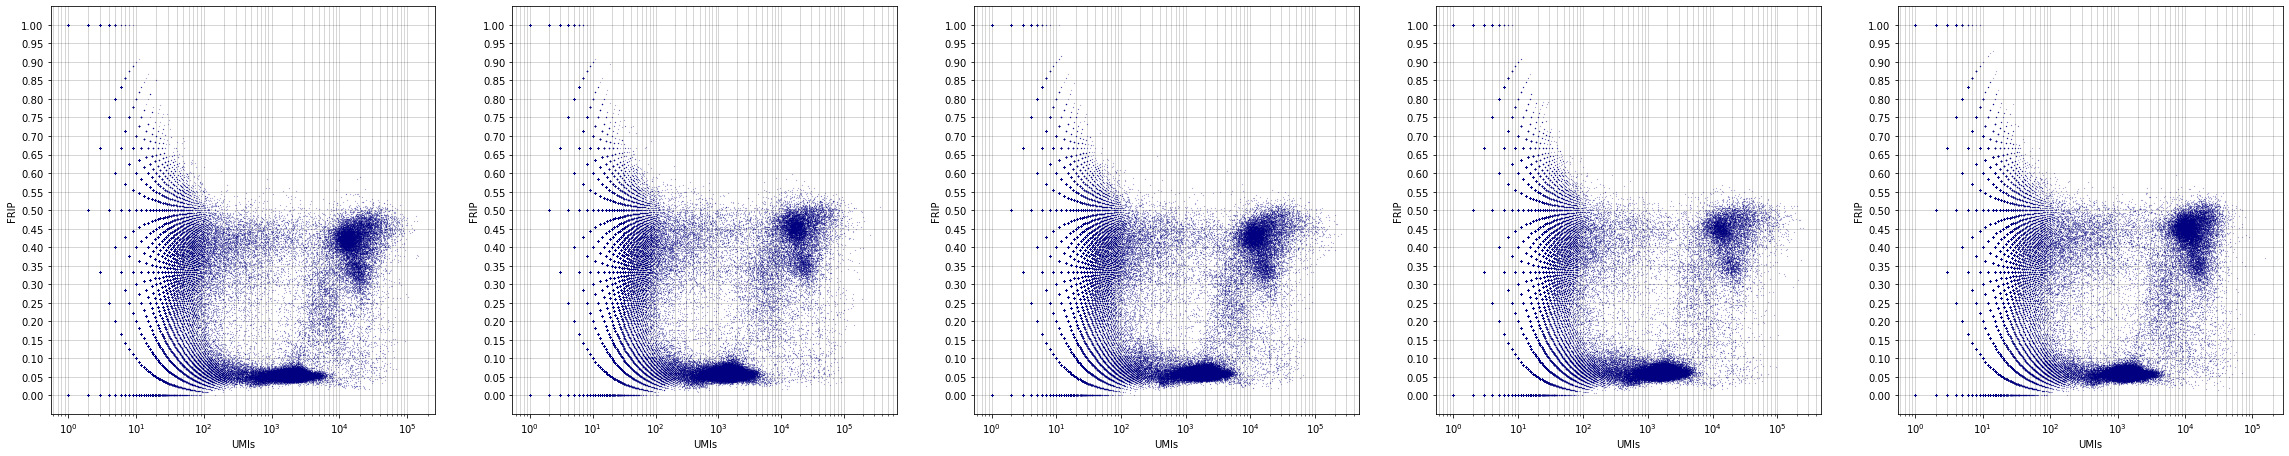

In [5]:
fig, axes = plt.subplots(1,len(samples),figsize=(40,7.5))
for sample, ax in zip(samples,np.ravel(axes)):
    ax.plot(data['umis'][sample], data['frip'][sample], linewidth=0,marker='.',color='navy',markersize=0.25);
    ax.set_xscale('log');
    ax.set_yticks(np.arange(0,1.05,0.05));
    ax.grid(which='both',alpha=0.2,color='k');
    ax.set_ylabel('FRIP');
    ax.set_xlabel('UMIs');

# Draw Gates and Subset

In [6]:
gates_list = list()
gates_list.append(np.array([(5e3, 0.25), (9e4, 0.25), (9e4, 0.55), (5e3, 0.55)]))
gates_list.append(np.array([(5e3, 0.27), (9e4, 0.27), (9e4, 0.55), (5e3, 0.55)]))
gates_list.append(np.array([(4e3, 0.25), (9e4, 0.25), (9e4, 0.55), (4e3, 0.55)]))
gates_list.append(np.array([(5e3, 0.27), (1e5, 0.27), (1e5, 0.55), (5e3, 0.55)]))
gates_list.append(np.array([(3e3, 0.25), (6e4, 0.25), (6e4, 0.55), (3e3, 0.55)]))

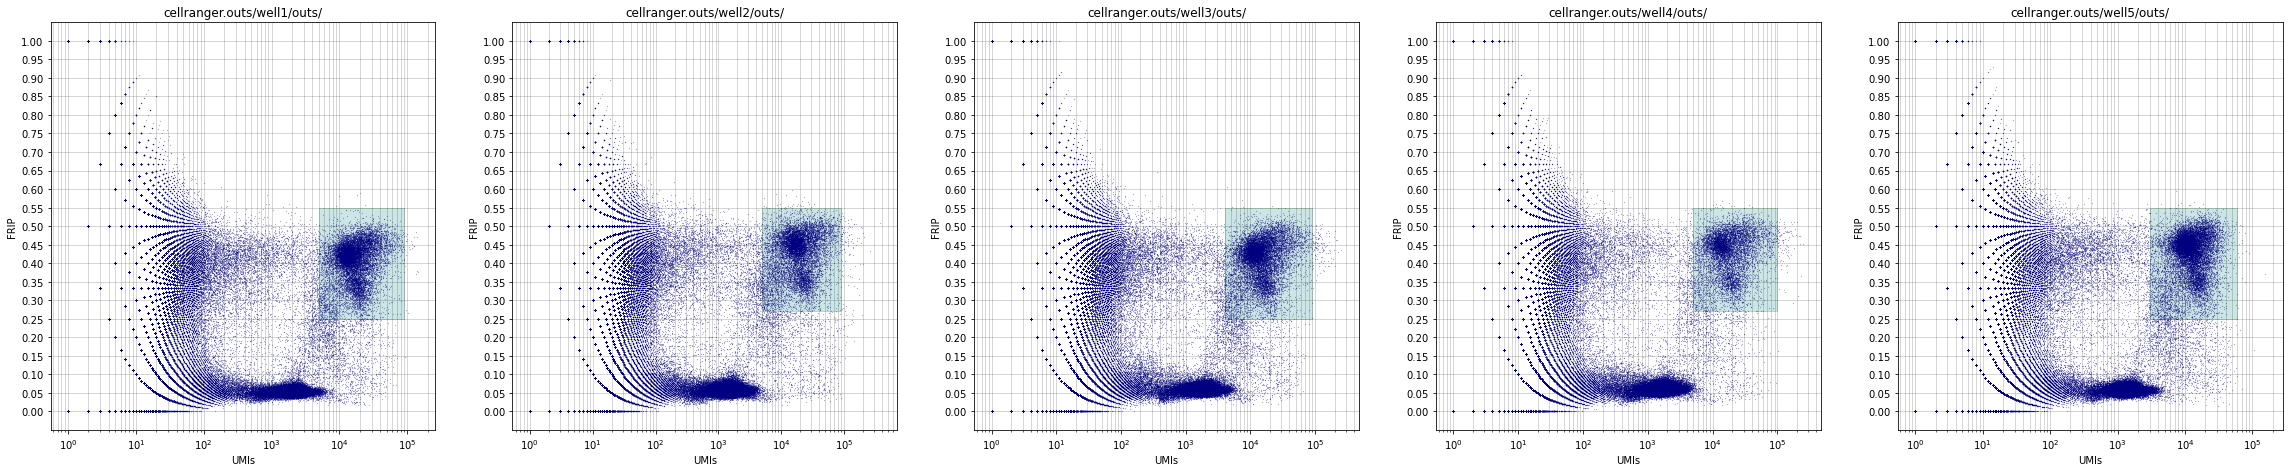

In [7]:
fig, axes = plt.subplots(1,len(samples),figsize=(40,7.5))
for sample, ax, gates in zip(samples,np.ravel(axes), gates_list):
    ax.plot(data['umis'][sample], data['frip'][sample], linewidth=0,marker='.',color='navy',markersize=0.25);
    ax.set_xscale('log');
    ax.set_yticks(np.arange(0,1.05,0.05));
    ax.grid(which='both',alpha=0.2,color='k');
    ax.set_ylabel('FRIP');
    ax.set_xlabel('UMIs');
    ax.set_title(sample)
    gatepatch = patches.Polygon(gates,linewidth=1,edgecolor='green',facecolor='teal',alpha=0.2)
    ax.add_patch(gatepatch);

In [8]:
data['cells'] = dict()
for sample, gates in zip(samples, gates_list):
    pointsmap = map(Point,data['umis'][sample],data['frip'][sample])
    polygon = Polygon(gates)
    data['cells'][sample] = list()
    for i in tqdm(pointsmap,total=len(data['umis'][sample])):
        data['cells'][sample].append(polygon.contains(i))

  0%|          | 0/678031 [00:00<?, ?it/s]

  0%|          | 0/674027 [00:00<?, ?it/s]

  0%|          | 0/667318 [00:00<?, ?it/s]

  0%|          | 0/648177 [00:00<?, ?it/s]

  0%|          | 0/646123 [00:00<?, ?it/s]

Show the number of nuclei that will be retained with the current gating.

In [9]:
for sample in samples:
    print(sum(data['cells'][sample]))
    data['cells'][sample] = data['sc'][sample].iloc[data['cells'][sample],:]

11898
9646
11308
7441
13275


In [10]:
sum([len(data['cells'][sample]) for sample in samples])

53568

# Export

Export the nuclei barcodes so that they can be used to subset the data and for further processing.

In [14]:
try:
    os.mkdir(prefix + 'bcs/')
except FileExistsError:
    pass

In [15]:
for sample in samples:
    with open(prefix + 'bcs/%s_bcs.tsv' % sample.split('/')[1], 'w') as file:
        for i in data['cells'][sample].index:
            file.write(i + '\n')